# 图像处理的一般流程
    预处理
    导入模块
    新建一个文件夹用来存放处理的图片
### 1、数据准备
    分别对数据图片进行类别分类和标注化分类（转化为数字标签）
    随机拆分数据集

### 2、使用RGB颜色直方图做特征训练分类器
    设置RGB颜色直方图    
    hist = cv2.calcHist([img], [0,1,2], None, [8]*3, [0,256]*3)
    提取直方图特征
    np.row_stack([transform(img) for img in images])
###### 2.1、使用随机森林训练分类器（建模）
    因为一共有4类，所以不用太深的决策树，因为是分类树，所以使用默认的GINI值，为了运算，使用15颗树
    训练
    保存
    评估随机森林分类器（准确率，召回率，f1分数，支持度）
######  2.2、使用逻辑回归训练分类器
    为了过拟合，使用的是L2正则，保持随机种子不变
    训练
    保存
    评估随机森林分类器（准确率，召回率，f1分数，支持度）
    
### 3、使用Lab颜色直方图做特征训练分类器
    设置Lab颜色直方图
    提取直方图特征
###### 3.1、使用随机森林训练分类器（建模）
    训练
    保存
    评估随机森林分类器（准确率，召回率，f1分数，支持度）
######  3.2、使用逻辑回归训练分类器
    训练
    保存
    评估随机森林分类器（准确率，召回率，f1分数，支持度

### 4、使用分类器对新图像分类
    定义一个用于分类的Predictor类
    对新图像进行分类




In [1]:
import numpy as np  #计算库
import cv2 ##########opencv
import os   #######文件操作
from sklearn.model_selection import train_test_split  ##数据集的拆分
from sklearn.preprocessing import LabelEncoder   
# 标准化标签，将标签值统一转换成range(标签值个数-1)范围内
from sklearn.ensemble import RandomForestClassifier  #随机森林
from sklearn.linear_model import LogisticRegression  #逻辑回归
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

'''
confusion_matrix 误分类矩阵
precision_recall_fscore_support  正确率，召回率，F1值

'''


import pandas as pd
import pickle                      ##用来存储图像结构化的数据

In [2]:
# from sklearn.preprocessing import LabelEncoder  
'''
标准化标签，将标签值统一转换成range(标签值个数-1)范围内
In [1]: from sklearn import preprocessing
   ...: le = preprocessing.LabelEncoder()
   ...: le.fit([1,2,2,6,3])
   ...:
Out[1]: LabelEncoder()

In [2]: le.classes_
Out[2]: array([1, 2, 3, 6])

In [3]: le.transform([1,1,3,6,2])
Out[3]: array([0, 0, 2, 3, 1], dtype=int64

In [4]: le.inverse_transform([0, 0, 2, 3, 1])
Out[4]: array([1, 1, 3, 6, 2])




In [5]: from sklearn import preprocessing
   ...: le =preprocessing.LabelEncoder()
   ...: le.fit(["paris", "paris", "tokyo", "amsterdam"])
   ...: print('标签个数:%s'% le.classes_)
   ...: print('标签值标准化:%s' % le.transform(["tokyo", "tokyo", "paris"]))
   ...: print('标准化标签值反转:%s' % le.inverse_transform([2, 2, 1]))
   ...:
标签个数:['amsterdam' 'paris' 'tokyo']
标签值标准化:[2 2 1]
标准化标签值反转:['tokyo' 'tokyo' 'paris']

'''

##新建一个文件夹用来存放数据
output_dir = 'output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 数据准备

In [3]:
image_dir = "data/images"

In [13]:
images = []
labels = []
for fname in os.listdir(image_dir):
    if not fname.startswith('image'):continue  #跳过不是图片的文件
    fpath=os.path.join(image_dir,fname)   #指定文件夹下，文件
           #     根据文件名，提取图片分类
    lab = fpath.split("_")[1] #得到得是不同后缀的图片名
        #     print(lab)
           #RGB模式读取图片
    img = cv2.imread(fpath,cv2.IMREAD_COLOR)  #得到得是多维的矩阵
    images.append(img)
    labels.append(lab)
print(labels)

['crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'crocus', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'dai

In [17]:
# 将图片标签ID化
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
y,len(y)

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int64), 234)

In [37]:
# 训练集，测试集划分
train_idx, test_idx = train_test_split(range(len(y)), test_size=0.2, stratify=y, random_state=1234)
train_y = y[train_idx]
test_y = y[test_idx]
test_y,train_y #随机拆分

(array([3, 3, 1, 1, 2, 3, 2, 3, 2, 0, 1, 1, 3, 2, 1, 3, 0, 1, 2, 0, 3, 2,
        1, 3, 2, 2, 3, 1, 2, 0, 3, 2, 3, 2, 0, 0, 1, 0, 3, 0, 1, 3, 0, 0,
        1, 1, 3], dtype=int64),
 array([1, 1, 0, 1, 1, 0, 1, 1, 0, 3, 3, 0, 0, 0, 1, 1, 3, 1, 2, 2, 1, 2,
        1, 1, 1, 3, 3, 3, 3, 2, 0, 3, 1, 1, 2, 1, 3, 3, 0, 0, 2, 2, 0, 3,
        0, 3, 1, 3, 0, 3, 0, 2, 3, 1, 2, 0, 3, 2, 3, 1, 3, 1, 0, 2, 2, 2,
        0, 3, 2, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 3, 2, 1, 3, 3, 0, 3, 3, 2,
        3, 3, 1, 3, 0, 0, 1, 0, 1, 2, 2, 3, 3, 2, 3, 1, 3, 2, 2, 3, 0, 0,
        2, 3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 0, 1, 1, 2, 1, 2, 2, 0, 0, 1,
        3, 3, 3, 0, 0, 3, 0, 3, 2, 1, 3, 2, 2, 0, 3, 1, 2, 0, 3, 2, 2, 1,
        3, 3, 0, 0, 2, 2, 3, 1, 3, 1, 0, 2, 3, 1, 0, 3, 1, 2, 0, 1, 1, 3,
        2, 1, 2, 2, 0, 0, 2, 3, 1, 3, 1], dtype=int64))

## 2、使用RGB颜色直方图做特征训练分类器

#### 2.1、计算RGB颜色直方图

In [33]:
# 定义特征转化函数
def transform(img):
    # 每个通道等分为8组后计算直方图
    hist = cv2.calcHist([img], [0,1,2], None, [8]*3, [0,256]*3)
    return hist.ravel()    # 将8x8x8的多维数组拉平

help(cv2.calcHist)

Help on built-in function calcHist:

calcHist(...)
    calcHist(images, channels, mask, histSize, ranges[, hist[, accumulate]]) -> hist
    .   @overload



In [36]:
# cv2.calcHist(images, channels, mask, histSize, 
            #ranges[, hist[, accumulate]]) → hist

# 参数说明
# images: 图片列表
# channels: 需要计算直方图的通道。[0]表示计算通道0的直方图，
                #[0,1,2]表示计算通道0,1,2所表示颜色的直方图

# mask: 蒙版，只计算值>0的位置上像素的颜色直方图，取None表示无蒙版
# histSize: 每个维度上直方图的大小，[8]表示把通道0的颜色取值等分
                    #为8份后计算直方图

# ranges: 每个维度的取值范围，[lower0, upper0, lower1, upper1, ...]
                    #，lower可以取到，upper无法取到

# hist: 保存结果的ndarray对象
# accumulate: 是否累积，如果设置了这个值，hist不会被清零，
                      #直方图结果直接累积到hist中
    
    

# 提取每个图像的直方图特征
x = np.row_stack([transform(img) for img in images])
len(x),x   #####################内部怎么计算的

(234, array([[9.0558e+04, 1.9131e+04, 2.6000e+01, ..., 0.0000e+00, 7.4000e+01,
         7.8600e+03],
        [7.4880e+03, 4.5000e+01, 0.0000e+00, ..., 9.0000e+00, 1.5300e+02,
         7.1500e+02],
        [1.7427e+04, 1.4260e+03, 0.0000e+00, ..., 0.0000e+00, 5.0300e+02,
         1.0540e+03],
        ...,
        [2.8800e+03, 6.2100e+03, 5.1330e+03, ..., 0.0000e+00, 8.0000e+00,
         9.0000e+00],
        [2.7635e+04, 9.2820e+03, 3.6960e+03, ..., 0.0000e+00, 0.0000e+00,
         5.0000e+00],
        [6.4000e+01, 1.8600e+02, 1.3510e+03, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]], dtype=float32))

In [23]:
train_x = x[train_idx, :]
test_x = x[test_idx, :]

In [38]:
test_x,train_x

(array([[1.44430e+04, 1.20000e+02, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 0.00000e+00],
        [1.32152e+05, 5.90000e+02, 2.00000e+00, ..., 0.00000e+00,
         4.00000e+00, 5.47000e+02],
        [7.58560e+04, 3.98300e+03, 2.24000e+02, ..., 0.00000e+00,
         2.37000e+02, 2.25400e+03],
        ...,
        [1.17239e+05, 7.50000e+01, 0.00000e+00, ..., 0.00000e+00,
         1.20000e+01, 3.60000e+02],
        [1.17244e+05, 7.40000e+01, 0.00000e+00, ..., 0.00000e+00,
         1.30000e+01, 3.60000e+02],
        [1.32150e+04, 4.44100e+03, 3.32000e+02, ..., 0.00000e+00,
         3.41000e+02, 1.52200e+03]], dtype=float32),
 array([[3.05053e+05, 3.80000e+01, 0.00000e+00, ..., 0.00000e+00,
         7.88500e+03, 1.86380e+04],
        [4.22780e+04, 2.82000e+03, 0.00000e+00, ..., 0.00000e+00,
         0.00000e+00, 8.00000e+00],
        [2.71790e+04, 1.03810e+04, 1.55100e+03, ..., 0.00000e+00,
         4.00000e+00, 1.09600e+03],
        ...,
        [3.59050e+04, 2.50000e+01, 0.00

#### 2.2随机森林模型的建立

In [27]:
# RandomForestClassifier
# 常用参数
# n_estimators: 整数，树的个数，默认10，树越多拟合效果越好，也越容易过拟合
# criterion: 衡量树的某次分裂好坏的指标，可选值有{'gini', 'entropy'}
# max_features: 寻找最佳分裂时最多使用多少个特征
#     如果为int，表示每次分裂时的最大特征数
#     如果为float，则最大特征数为int(max_features * n_features)
#     如果为'auto'，则max_features=sqrt(n_features)
#     如果为'sqrt'，则max_features=sqrt(n_features)
#     如果为'log2'，则max_features=log2(n_features)
#     如果为None，则max_features=n_features
# max_depth: int或None，每个树最大的深度。默认None，表示每个树节点会一直分裂直到所有
#     的叶子节点都是纯的，或者包含min_samples_split个样本。深度越深，越容易过拟合。
# min_samples_split: int或float，默认为2，对一个节点进行分裂时，至少需要这么多样本。
#     int: 表示样本数
#     float: 表示比例，即最小样本数为 ceil(min_samples_split * n_samples)
# min_samples_leaf: int或float，默认为1，叶子节点至少需要这么多样本
#     int: 表示样本数
#     float: 表示比例，样本数为 ceil(min_samples_leaf * n_samples)



model = RandomForestClassifier(n_estimators=15, max_depth=3, random_state=1234)    
# random_state代表给定的随机数不会再变化

In [28]:
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [39]:
# 保存模型
def save_model(model, label_encoder, output_file):
    try:
        with open(output_file, 'wb') as outfile:
            pickle.dump({
                'model': model,
                'label_encoder': label_encoder
            }, outfile)
        return True
    except:
        return False

In [42]:
save_model(model, label_encoder, os.path.join(output_dir, 'model_rf1.pkl'))

True

#### 2.3 评估随机森林分类器

In [43]:
# 计算各项评价指标
def eval_model(y_true, y_pred, labels):
    # 计算每个分类的Precision, Recall, f1, support #最后是支持度，满足所有条件的人数占总数的比值
    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred)
    # 计算总体的平均Precision, Recall, f1, support
    tot_p = np.average(p, weights=s)
    tot_r = np.average(r, weights=s)
    tot_f1 = np.average(f1, weights=s)
    tot_s = np.sum(s)
    res1 = pd.DataFrame({
        u'Label': labels,
        u'Precision': p,
        u'Recall': r,
        u'F1': f1,
        u'Support': s
    })
    res2 = pd.DataFrame({
        u'Label': [u'总体'],
        u'Precision': [tot_p],
        u'Recall': [tot_r],
        u'F1': [tot_f1],
        u'Support': [tot_s]
    })
    res2.index = [999]
    res = pd.concat([res1, res2])
    # 计算混淆矩阵
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_pred), columns=labels, index=labels)
    return conf_mat, res[[u'Label', u'Precision', u'Recall', u'F1', u'Support']]

In [69]:
# 在测试集上计算每个图片的预测分类
y_pred = model.predict(test_x)
y_pred

array([3, 3, 2, 0, 2, 3, 2, 3, 0, 0, 2, 1, 3, 2, 1, 3, 0, 0, 2, 0, 3, 2,
       1, 3, 2, 2, 3, 0, 2, 0, 3, 2, 3, 2, 2, 1, 1, 0, 3, 2, 0, 3, 0, 1,
       1, 1, 3], dtype=int64)

In [45]:
# 评估模型
conf_mat, evalues = eval_model(test_y, y_pred,label_encoder.classes_)
'''
test_y  #测试集
y_pred  #特征分类的预测集
'''


In [46]:
# 混淆矩阵
conf_mat

,crocus,daisy,pansy,sunflower
crocus,4,3,3,0
daisy,1,11,0,0
pansy,1,2,8,0
sunflower,0,1,0,13


In [70]:
evalues  #各类分数的平均值，最后的支持度是计算总和

,Label,Precision,Recall,F1,Support
0,crocus,0.545455,0.600000,0.571429,10
1,daisy,0.750000,0.500000,0.600000,12
2,pansy,0.714286,0.909091,0.800000,11
3,sunflower,1.000000,1.000000,1.000000,14
999,总体,0.772589,0.765957,0.759878,47


#### 2.4 使用逻辑回归训练分类器

In [47]:
model = LogisticRegression(penalty='l2', C=1, random_state=1234)
model.fit(train_x, train_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
save_model(model, label_encoder, os.path.join(output_dir, 'model_lr1.pkl'))

True

#### 2.5 评估逻辑回归分类器

In [49]:
# 在测试集上计算每个图片的预测分类
y_pred = model.predict(test_x)
# 评估模型
conf_mat, evalues = eval_model(test_y, y_pred, label_encoder.classes_)

In [50]:
# 混淆矩阵
conf_mat

,crocus,daisy,pansy,sunflower
crocus,4,1,5,0
daisy,1,10,1,0
pansy,2,1,8,0
sunflower,0,0,1,13


In [51]:
# 各项评价指标
evalues

,Label,Precision,Recall,F1,Support
0,crocus,0.571429,0.400000,0.470588,10
1,daisy,0.833333,0.833333,0.833333,12
2,pansy,0.533333,0.727273,0.615385,11
3,sunflower,1.000000,0.928571,0.962963,14
999,总体,0.757042,0.744681,0.743757,47


# 3 使用Lab颜色直方图做特征训练分类器

#### 3.1 计算L\*a\*b\*颜色直方图

In [52]:
# 定义特征转化函数
def transform(img):
    # 将图片从BGR模式转化为Lab模式
    img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    # 每个通道等分为8组后计算直方图
    hist = cv2.calcHist([img], [0,1,2], None, [8]*3, [0,256]*3)
    # 将8x8x8的多维数组拉平
    return hist.ravel()

In [53]:
# 提取每个图像的直方图特征
x = np.row_stack([transform(img) for img in images])

In [54]:
train_x = x[train_idx, :]
test_x = x[test_idx, :]

#### 3.2 使用随机森林训练分类器

In [55]:
model = RandomForestClassifier(n_estimators=15, max_depth=3, random_state=1234)
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=1,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

In [56]:
save_model(model, label_encoder, os.path.join(output_dir, 'model_rf2.pkl'))

True

#### 3.3 评估随机森林分类器

In [57]:
# 在测试集上计算每个图片的预测分类
y_pred = model.predict(test_x)
# 评估模型
conf_mat, evalues = eval_model(test_y, y_pred, label_encoder.classes_)

In [58]:
# 混淆矩阵
conf_mat

,crocus,daisy,pansy,sunflower
crocus,4,3,3,0
daisy,0,12,0,0
pansy,1,1,8,1
sunflower,0,0,0,14


In [59]:
# 各项评价指标
evalues

,Label,Precision,Recall,F1,Support
0,crocus,0.800000,0.400000,0.533333,10
1,daisy,0.750000,1.000000,0.857143,12
2,pansy,0.727273,0.727273,0.727273,11
3,sunflower,0.933333,1.000000,0.965517,14
999,总体,0.809929,0.808511,0.790134,47


#### 3.4 使用逻辑回归训练分类器

In [60]:
model = LogisticRegression(penalty='l2', C=1, random_state=1234)
model.fit(train_x, train_y)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1234, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [61]:
save_model(model, label_encoder, os.path.join(output_dir, 'model_lr2.pkl'))

True

#### 3.5 评估逻辑回归分类器

In [62]:
# 在测试集上计算每个图片的预测分类
y_pred = model.predict(test_x)
# 评估模型
conf_mat, evalues = eval_model(test_y, y_pred, label_encoder.classes_)

In [63]:
# 混淆矩阵
conf_mat

,crocus,daisy,pansy,sunflower
crocus,6,2,2,0
daisy,4,6,2,0
pansy,1,0,10,0
sunflower,0,0,0,14


In [64]:
# 各项评价指标
evalues

,Label,Precision,Recall,F1,Support
0,crocus,0.545455,0.600000,0.571429,10
1,daisy,0.750000,0.500000,0.600000,12
2,pansy,0.714286,0.909091,0.800000,11
3,sunflower,1.000000,1.000000,1.000000,14
999,总体,0.772589,0.765957,0.759878,47


# 4 使用分类器对新图像分类 

In [65]:
# 定义一个用于分类的Predictor类
class Predictor(object):
    
    def __init__(self, model_file):
        with open(model_file, 'rb') as infile:
            self.loaded = pickle.load(infile)
        self.model = self.loaded['model']
        self.label_encoder = self.loaded['label_encoder']

    # 实现分类逻辑
    def predict(self, img_file):
        # 读取图像文件
        img = cv2.imread(img_file, cv2.IMREAD_COLOR)
        # 颜色空间转化为Lab
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        # 计算颜色直方图
        x = cv2.calcHist([img], [0,1,2], None, [8]*3, [0,256]*3)   # 返回(8, 8, 8)的ndarray
        x = x.reshape((1, -1))    # 变形为(1, 512)的ndarray
        # 预测分类
        y = self.model.predict(x)
        # 转化为原始标签
        label = self.label_encoder.inverse_transform(y)  #翻转
        return label

In [66]:
predictor = Predictor(os.path.join(output_dir, 'model_rf2.pkl'))

In [68]:
# 对新图片进行分类
predictor.predict('data/images/image_crocus_0001.png')

D:\Anaconda3\haha\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['crocus'], dtype='<U9')

(-0.5, 499.5, 685.5, -0.5)

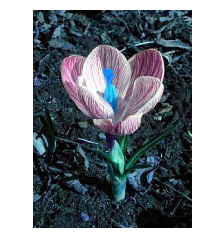

In [5]:
import cv2
from matplotlib import pyplot as plt
pic_file = 'data/images/image_crocus_0001.png'

img_bgr = cv2.imread(pic_file,cv2.IMREAD_COLOR)
plt.imshow(img_bgr, cmap='gray')
plt.axis('off')